In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests
print(sklearn.__version__)
print(np.__version__)

1.6.1
1.23.5


In [52]:
poverty_df = pd.read_csv('share-of-population-living-in-extreme-poverty.csv')
inflation_df = pd.read_csv('Economic Indicators And Inflation.csv')

In [53]:
print("Poverty Data Sample:")
print(poverty_df.head())
print("\nPoverty Data Info:")
print(poverty_df.info())
print("\nPoverty Data Stats:")
print(poverty_df.describe())

Poverty Data Sample:
   Country  Year  Share below $2.15 a day
0  Albania  1996                 0.534846
1  Albania  2002                 1.092647
2  Albania  2005                 0.591086
3  Albania  2008                 0.199925
4  Albania  2012                 0.620691

Poverty Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country                  2705 non-null   object 
 1   Year                     2705 non-null   int64  
 2   Share below $2.15 a day  2705 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 63.5+ KB
None

Poverty Data Stats:
              Year  Share below $2.15 a day
count  2705.000000              2705.000000
mean   2006.331238                11.613670
std      10.924993                18.430307
min    1963.000000                 0.000000
25%    1999.000000    

In [54]:
print("\nInflation Data Sample:")
print(inflation_df.head())
print("\nInflation Data Info:")
print(inflation_df.info())
print("\nInflation Data Stats:")
print(inflation_df.describe())


Inflation Data Sample:
  Country   Year   GDP (in billion USD)   Inflation Rate (%)  \
0     USA   2010                15000.0                 1.64   
1     USA   2011                15500.0                 3.16   
2     USA   2012                16000.0                 2.07   
3     USA   2013                16500.0                 1.50   
4     USA   2014                17000.0                 1.62   

    Unemployment Rate (%)   Economic Growth (%)  
0                    9.63                  2.55  
1                    8.94                  1.53  
2                    8.10                  2.28  
3                    7.70                  1.84  
4                    7.25                  2.53  

Inflation Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 304 non-null    object 
 1    

In [55]:
poverty_df.columns = poverty_df.columns.str.strip().str.replace(' ', '_').str.lower()
inflation_df.columns = inflation_df.columns.str.strip().str.replace(' ', '_').str.replace('(%?)', '', regex=True).str.lower()

# Rename the awkwardly named poverty column for clarity
poverty_df.rename(columns={'share_below_$2.15_a_day': 'poverty_rate'}, inplace=True)
print("--- Cleaned Column Names ---")
print("Poverty DF Columns:", poverty_df.columns)
print("Inflation DF Columns:", inflation_df.columns)


# Step 2: Standardize Country Names in the inflation dataset
country_map = {
    'USA': 'United States',
    'UK': 'United Kingdom'
}
inflation_df['country'] = inflation_df['country'].replace(country_map)
print("\n--- Standardized Country Names in inflation_df ---")
print(sorted(inflation_df['country'].unique()))


# Step 3: Filter the poverty data
# 3a: Remove non-country aggregate rows (like 'World', '(PIP)', etc.)
original_rows = len(poverty_df)
poverty_df_filtered = poverty_df[~poverty_df['country'].str.contains(r'\(|World', regex=True)].copy()
print(f"\n--- Filtering Aggregates from Poverty Data ---")
print(f"Removed {original_rows - len(poverty_df_filtered)} non-country rows.")

# 3b: Filter for the relevant time period (2010 onwards, based on inflation_df)
poverty_df_filtered = poverty_df_filtered[poverty_df_filtered['year'] >= 2010]
print(f"Poverty data now filtered for years >= 2010.")


# Step 4: Merge the two dataframes
# We use an 'inner' merge to ensure we only have rows with data from both sources.
merged_df = pd.merge(poverty_df_filtered, inflation_df, on=['country', 'year'], how='inner')

print("\n\n--- MASTER MERGED DATAFRAME ---")
print("\nMerged Data Info:")
merged_df.info()

print("\nMerged Data Sample (First 10 rows):")
print(merged_df.head(10))

print("\nMissing values in merged data:")
print(merged_df.isnull().sum())

--- Cleaned Column Names ---
Poverty DF Columns: Index(['country', 'year', 'poverty_rate'], dtype='object')
Inflation DF Columns: Index(['country', 'year', 'gdp_(in_billion_usd)', 'inflation_rate_()',
       'unemployment_rate_()', 'economic_growth_()'],
      dtype='object')

--- Standardized Country Names in inflation_df ---
['Australia', 'Bangladesh', 'Brazil', 'Canada', 'China', 'France', 'Germany', 'India', 'Indonesia', 'Italy', 'Japan', 'Malaysia', 'Pakistan', 'Russia', 'Saudi Arabia', 'South Korea', 'Turkey', 'United Kingdom', 'United States']

--- Filtering Aggregates from Poverty Data ---
Removed 555 non-country rows.
Poverty data now filtered for years >= 2010.


--- MASTER MERGED DATAFRAME ---

Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               167 non-null    object 
 1   year 

--- Final Corrected Column Names ---
Index(['country', 'year', 'poverty_rate', 'gdp_billion_usd', 'inflation_rate',
       'unemployment_rate', 'economic_growth'],
      dtype='object')
-----------------------------------

Generating visualizations...


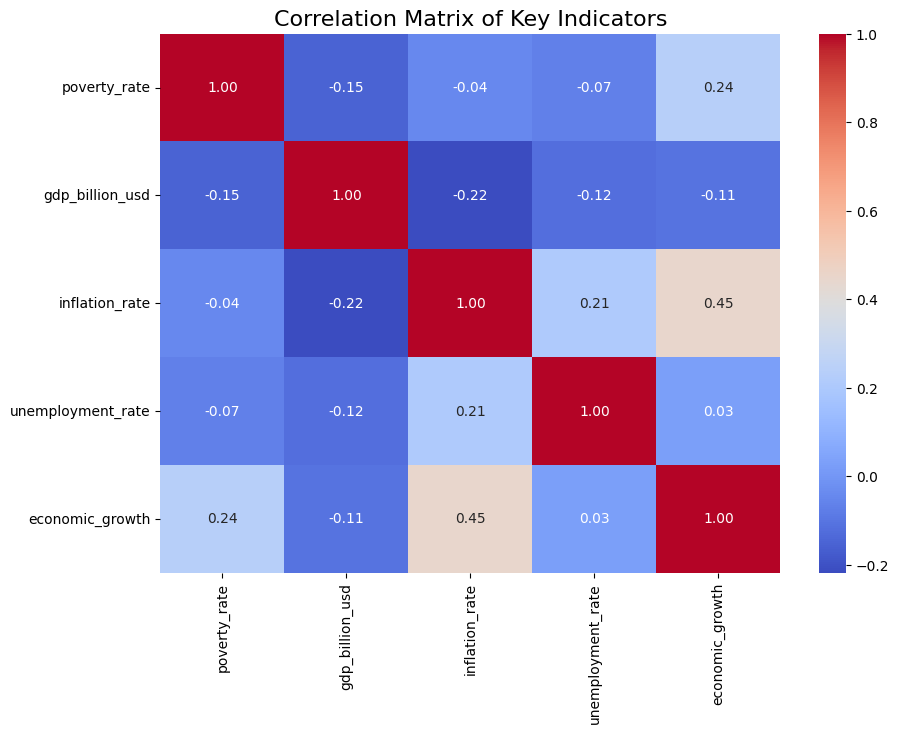

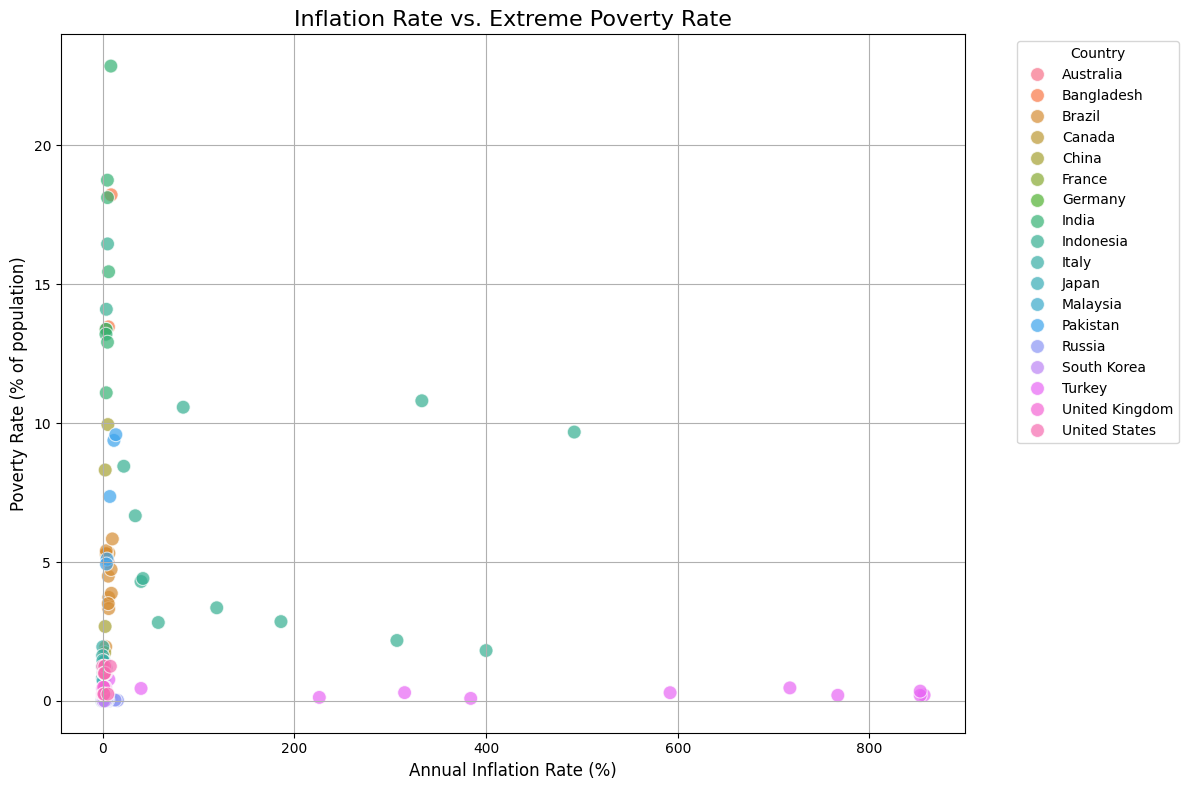


Splitting data for modeling...

--- Data Splitting Complete ---
Total samples: 167
Training samples (X_train): 133
Testing samples (X_test): 34


In [56]:
# Step 5: Clean up column names in the merged dataframe
merged_df.rename(columns={
    'gdp_(in_billion_usd)': 'gdp_billion_usd',
    'inflation_rate_()': 'inflation_rate',
    'unemployment_rate_()': 'unemployment_rate',
    'economic_growth_()': 'economic_growth'
}, inplace=True)

print("--- Final Corrected Column Names ---")
print(merged_df.columns)
print("-" * 35)


# --- Phase 3: Exploratory Data Analysis (EDA) ---
print("\nGenerating visualizations...")

# 1. Correlation Heatmap
plt.figure(figsize=(10, 7))
# Now this list of numeric columns will match the dataframe's columns exactly
numeric_cols = ['poverty_rate', 'gdp_billion_usd', 'inflation_rate', 'unemployment_rate', 'economic_growth']
sns.heatmap(merged_df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Indicators', fontsize=16)
plt.show()

# 2. Scatter Plot: Our Core Question
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='inflation_rate', y='poverty_rate', hue='country', s=100, alpha=0.7)
plt.title('Inflation Rate vs. Extreme Poverty Rate', fontsize=16)
plt.xlabel('Annual Inflation Rate (%)', fontsize=12)
plt.ylabel('Poverty Rate (% of population)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Country')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Phase 4: Prepare Data for Machine Learning ---

print("\nSplitting data for modeling...")

# Define our features (X) and our target (y)
features = ['gdp_billion_usd', 'inflation_rate', 'unemployment_rate', 'economic_growth']
target = 'poverty_rate'

X = merged_df[features]
y = merged_df[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Data Splitting Complete ---")
print(f"Total samples: {len(merged_df)}")
print(f"Training samples (X_train): {len(X_train)}")
print(f"Testing samples (X_test): {len(X_test)}")


--- Training and Evaluating Models ---

--- Results for Linear Regression ---
Mean Absolute Error (MAE): 3.31
Mean Squared Error (MSE): 17.84
R-squared (R2): 0.00
------------------------------

--- Results for Random Forest ---
Mean Absolute Error (MAE): 1.85
Mean Squared Error (MSE): 10.66
R-squared (R2): 0.40
------------------------------

--- Results for Decision Tree ---
Mean Absolute Error (MAE): 2.06
Mean Squared Error (MSE): 13.46
R-squared (R2): 0.25
------------------------------


--- Model Comparison and Conclusion ---
The best performing model is: Random Forest with an R2 score of 0.40

--- Feature Importances from Random Forest ---
             Feature  Importance
1     inflation_rate    0.468786
3    economic_growth    0.352454
2  unemployment_rate    0.090139
0    gdp_billion_usd    0.088622


--- Visualizing the Decision Tree ---


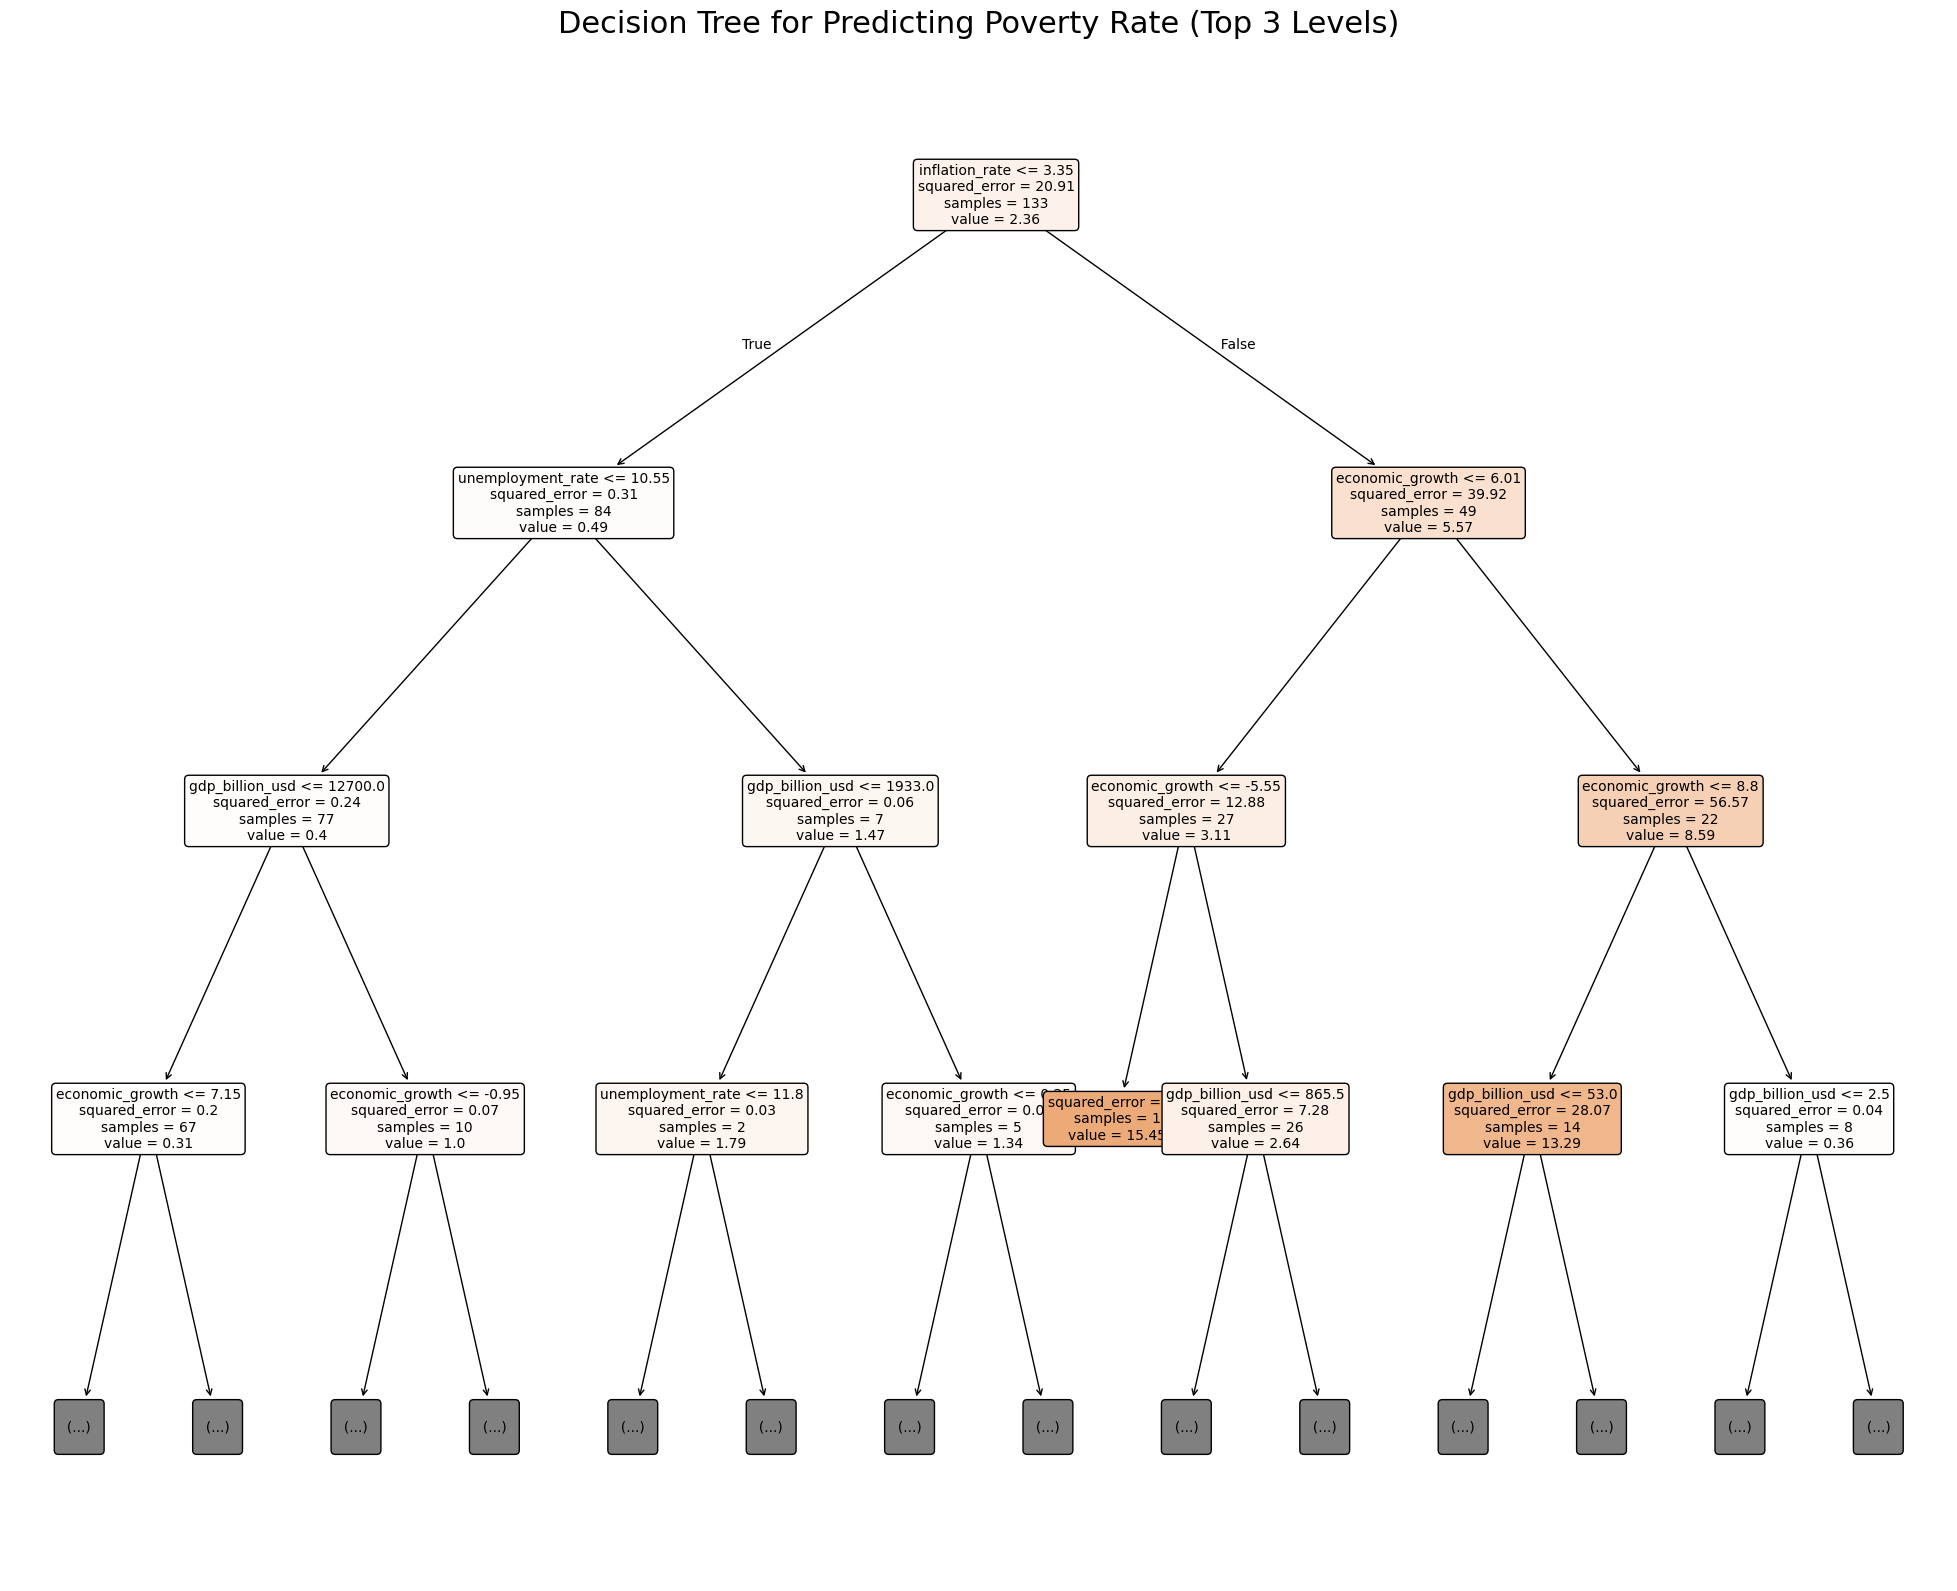


How to read the Decision Tree:
Each box is a decision point. It shows:
1. The rule (e.g., 'inflation_rate <= 10.5'). Data points answering 'True' go left, 'False' go right.
2. The 'mse' (mean squared error) at that node.
3. 'samples': how many data points from the training set are in this node.
4. 'value': the average poverty rate for those samples. This is the prediction for this node.
The color indicates the poverty level (darker orange = higher poverty).


In [57]:
# --- Phase 5: Modeling, Prediction, and Evaluation

from sklearn.tree import DecisionTreeRegressor, plot_tree

# Define ALL models we want to test from the start
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42) # Added here
}

# Dictionary to store the results for comparison
results = {}

print("\n--- Training and Evaluating Models ---")

# Loop through each model
for name, model in models.items():
    # 1. Train the model on the training data
    model.fit(X_train, y_train)

    # 2. Make predictions on the unseen test data
    y_pred = model.predict(X_test)

    # 3. Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}

    print(f"\n--- Results for {name} ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R2): {r2:.2f}")
    print("-" * 30)

# --- Final Model Interpretation ---
print("\n\n--- Model Comparison and Conclusion ---")
best_model_name = max(results, key=lambda name: results[name]['R2'])
best_model = models[best_model_name]
print(f"The best performing model is: {best_model_name} with an R2 score of {results[best_model_name]['R2']:.2f}")

# Let's show the feature importances from the Random Forest model
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances from Random Forest ---")
print(feature_importance_df)

# --- Visualize the Decision Tree to understand its rules ---
dt_model = models['Decision Tree']

print("\n\n--- Visualizing the Decision Tree ---")
plt.figure(figsize=(25, 20))
plot_tree(dt_model,
          feature_names=features,
          filled=True,          
          rounded=True,         
          fontsize=10,
          max_depth=3,          # Limit depth to keep it readable
          precision=2)          # Show values with 2 decimal places
          

plt.title("Decision Tree for Predicting Poverty Rate (Top 3 Levels)", fontsize=22)
plt.show()

print("\nHow to read the Decision Tree:")
print("Each box is a decision point. It shows:")
print("1. The rule (e.g., 'inflation_rate <= 10.5'). Data points answering 'True' go left, 'False' go right.")
print("2. The 'mse' (mean squared error) at that node.")
print("3. 'samples': how many data points from the training set are in this node.")
print("4. 'value': the average poverty rate for those samples. This is the prediction for this node.")
print("The color indicates the poverty level (darker orange = higher poverty).")

In [58]:
import joblib

# Package all the necessary objects into a single dictionary
app_data = {
    'models': models,
    'metrics': results,
    'features': features,
    'feature_importance': feature_importance_df # The dataframe we created
}

# Save this dictionary to a single file
filename = 'poverty_predictor_assets.joblib'
joblib.dump(app_data, filename)

print(f"All models and assets saved to {filename}")

All models and assets saved to poverty_predictor_assets.joblib
